# "Teach" the computer how to classify messages.
## To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans, to build a program that can automatically filter spam messages. Dataset can be downloaded from https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sms_start = pd.read_csv('SMSSpamCollection', sep= '\t', header=None, names=['Label', 'SMS'])
sms_start.sample(5)

,Label,SMS
41,ham,"Did I forget to tell you ? I want you , I need..."
1784,ham,No dear i do have free messages without any re...
571,ham,Yar lor wait 4 my mum 2 finish sch then have l...
2841,ham,BABE !!! I miiiiiiissssssssss you ! I need you...
1349,ham,"Nothing much, chillin at home. Any super bowl ..."


In [3]:
sms_start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
sms_start.Label.value_counts(normalize=True) * 100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

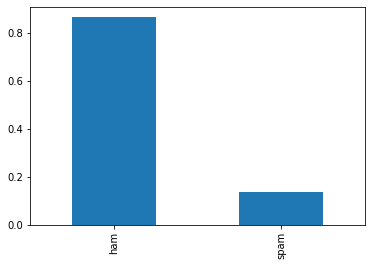

In [5]:
sms_start.Label.value_counts(normalize=True).plot.bar()

* There are total 5572 rows and 2 columns in the dataset
* 86.6% of the messages is ham and 13.4% of the messages are spam.

## A training set, which we'll use to 'train' the computer how to classify messages.
## A test set, which we'll use to test how good the spam filter is which classifying new messages
* We're going to keep 80% of our dataset for training, and 20% for testing.

In [6]:
# Firtst randomize the whole sample, using DataFrame.sample(frac=1, random_state=1), then cut 80% for traing 
# and 20% for testing
total_training = int(sms_start.shape[0] * 0.8)
random_sms = sms_start.sample(frac = 1, random_state=1).copy()
training_set = random_sms[0:total_training].copy()
test_set = random_sms[total_training:].copy()

In [7]:
training_set.Label.value_counts(normalize=True)

ham     0.86538
spam    0.13462
Name: Label, dtype: float64

In [8]:
test_set.Label.value_counts(normalize=True)

ham     0.868161
spam    0.131839
Name: Label, dtype: float64

In [9]:
training_set.tail()

,Label,SMS
4255,ham,"How about clothes, jewelry, and trips?"
1982,ham,"Sorry, I'll call later in meeting any thing re..."
5180,ham,Babe! I fucking love you too !! You know? Fuck...
4020,spam,U've been selected to stay in 1 of 250 top Bri...
371,ham,Hello my boytoy ... Geeee I miss you already a...


* Remove all the punction from the SMS column, and transform every letter in every word to lower case.

In [10]:
import re
def remove_punction(string):
    return (re.sub('\W+', ' ', string)).strip()

In [11]:
training_set['SMS'] = training_set.SMS.apply(remove_punction).str.lower()

In [12]:
test_set.head()

,Label,SMS
3482,ham,Wherre's my boytoy ? :-(
2131,ham,Later i guess. I needa do mcat study too.
3418,ham,But i haf enuff space got like 4 mb...
3424,spam,Had your mobile 10 mths? Update to latest Oran...
1538,ham,All sounds good. Fingers . Makes it difficult ...


In [13]:
test_set['SMS'] = test_set.SMS.apply(remove_punction).str.lower()
test_set.head()

,Label,SMS
3482,ham,wherre s my boytoy
2131,ham,later i guess i needa do mcat study too
3418,ham,but i haf enuff space got like 4 mb
3424,spam,had your mobile 10 mths update to latest orang...
1538,ham,all sounds good fingers makes it difficult to ...


In [14]:
#training_set.drop(['SMS'], axis=1, inplace=True)

In [15]:
#test_set.drop(['SMS'], axis = 1, inplace=True)

In [16]:
training_set.reset_index(inplace=True)
test_set.reset_index(inplace = True)

In [17]:
training_set.drop(['index'], inplace = True, axis = 1)
test_set.drop(['index'], axis = 1, inplace=True)
training_set.head(3)

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired


In [18]:
test_set.head(3)

,Label,SMS
0,ham,wherre s my boytoy
1,ham,later i guess i needa do mcat study too
2,ham,but i haf enuff space got like 4 mb


* Create a vocabulary for the messages in the training set. Should be a Python list containg all the unique words accross all messages.

In [19]:
training_set.SMS = training_set.SMS.str.split()
training_set.head()

,Label,SMS
0,ham,"[yep, by, the, pretty, sculpture]"
1,ham,"[yes, princess, are, you, going, to, make, me,..."
2,ham,"[welp, apparently, he, retired]"
3,ham,[havent]
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,..."


In [20]:
vocabulary = []
for word in training_set.SMS:
    vocabulary.extend(word)
vocabulary[:10]

['yep',
 'by',
 'the',
 'pretty',
 'sculpture',
 'yes',
 'princess',
 'are',
 'you',
 'going']

In [21]:
vocabulary = list(set(vocabulary))

* Create the dictionary for training set

In [22]:
word_counts_per_sms = {unique_word :[0] * len(training_set.SMS) for unique_word in vocabulary}

for index, sms in enumerate(training_set.SMS):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [23]:
word_count_df = pd.DataFrame(word_counts_per_sms)

In [24]:
word_count_df

,hitler,woohoo,educational,tomeandsaid,nyc,goals,nvq,facebook,2004,priority,...,indian,floppy,lightly,hows,shracomorsglsuplt,lips,spjanuary,hanumanji,great,url
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
sms_transform = pd.concat([training_set, word_count_df], axis=1)

In [26]:
sms_transform.head()

,Label,SMS,hitler,woohoo,educational,tomeandsaid,nyc,goals,nvq,facebook,...,indian,floppy,lightly,hows,shracomorsglsuplt,lips,spjanuary,hanumanji,great,url
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


\begin{equation}
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam) \\
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
\end{equation}
\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}} \\
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}

In [27]:
p_spam = training_set.Label.value_counts(normalize=True)['spam']
p_ham = training_set.Label.value_counts(normalize=True)['ham']

In [28]:
n_spam = training_set.loc[training_set.Label == 'spam', 'SMS'].str.len().sum()
n_ham = training_set.loc[training_set.Label == 'ham', 'SMS'].str.len().sum()
n_vocabulary = len(vocabulary)
alpha = 1
print('Total words in spam sms is {0}, total words in ham sms is {1}, unique words in training set is {2}, and \
smoothing value alpha is {3}'.format(
n_spam, n_ham, n_vocabulary, alpha))

Total words in spam sms is 15190, total words in ham sms is 57233, unique words in training set is 7782, and smoothing value alpha is 1


In [29]:
spam_word_probability = {word : 0 for word in vocabulary}
ham_word_probability = {word : 0 for word in vocabulary}

In [30]:
training_spam = sms_transform[sms_transform.Label == 'spam']
training_ham = sms_transform[sms_transform.Label == 'ham']

In [31]:
type(vocabulary)

list

In [32]:
for word in vocabulary:
    word_in_spam = training_spam[word].sum()
    word_in_ham = training_ham[word].sum()
    p_word_given_spam = (word_in_spam + alpha) / (n_spam + alpha * n_vocabulary)
    p_word_given_ham = (word_in_ham + alpha) / (n_ham + alpha * n_vocabulary)
    spam_word_probability[word] = p_word_given_spam
    ham_word_probability[word] = p_word_given_ham


The spam filter can be understood as a function that:
* Takes in as input a newe message $w_1, w_2, \ldots, w_n$
* Calculates P(Spam|w1,w2,...,wn) and P(Ham|w1,w2,...,wn)
* Compare those two values, >, <, = request human help

In [33]:
# filter function
import re

def classify(message):
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    # calculate p_spam_given_message and p_ham_given_message
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    for word in message:
        if word in vocabulary:
            p_spam_given_message *= spam_word_probability[word]
            p_ham_given_message *= ham_word_probability[word]
    
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|messsage):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal probabilities, have a human classify this!')

In [34]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3489598779101096e-25
P(Ham|messsage): 1.9380782419077522e-27
Label: Spam


In [35]:
classify('Sounds good, Tom, then see u there')

P(Spam|message): 2.4385273359614485e-25
P(Ham|messsage): 3.6893872875947e-21
Label: Ham


In [36]:
classify('Money reward')

P(Spam|message): 1.2755015932050846e-08
P(Ham|messsage): 9.212815731531301e-09
Label: Spam


In [37]:
# filter function to return label
import re

def classify_test_set(message):
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    # calculate p_spam_given_message and p_ham_given_message
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in vocabulary:
            p_spam_given_message *= spam_word_probability[word]
            p_ham_given_message *= ham_word_probability[word]
       
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [38]:
test_set['predicted'] = test_set.SMS.apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,wherre s my boytoy,ham
1,ham,later i guess i needa do mcat study too,ham
2,ham,but i haf enuff space got like 4 mb,ham
3,spam,had your mobile 10 mths update to latest orang...,spam
4,ham,all sounds good fingers makes it difficult to ...,ham


In [44]:
correct, total = 0,0
for index, row in test_set.iterrows():
    total += 1
    if row['Label'] == row['predicted']:
        correct += 1

In [45]:
accurancy = correct / total
print(accurancy)

0.9874439461883409


* Accurancy is 98.7%, which is high enough to be used to filter new message.

In [46]:
test_set['accurancy'] = test_set.apply(lambda row : 1 if row['Label'] == row['predicted'] else 0, axis='columns')

In [47]:
test_set

,Label,SMS,predicted,accurancy
0,ham,wherre s my boytoy,ham,1
1,ham,later i guess i needa do mcat study too,ham,1
2,ham,but i haf enuff space got like 4 mb,ham,1
3,spam,had your mobile 10 mths update to latest orang...,spam,1
4,ham,all sounds good fingers makes it difficult to ...,ham,1
...,...,...,...,...
1110,ham,we re all getting worried over here derek and ...,ham,1
1111,ham,oh oh den muz change plan liao go back have to...,ham,1
1112,ham,ceri u rebel sweet dreamz me little buddy c ya...,ham,1
1113,spam,text meet someone sexy today u can find a date...,spam,1


In [49]:
# Wrong conclusions
test_set[test_set.accurancy == 0]

,Label,SMS,predicted,accurancy
115,spam,not heard from u4 a while call me now am here ...,ham,0
136,spam,more people are dogging in your area now call ...,ham,0
153,ham,unlimited texts limited minutes,spam,0
160,ham,26th of july,spam,0
285,ham,nokia phone is lovly,spam,0
294,ham,a boy loved a gal he propsd bt she didnt mind ...,needs human classification,0
303,ham,no calls messages missed calls,spam,0
320,ham,we have sent jd for customer service cum accou...,spam,0
505,spam,oh my god i ve found your number again i m so ...,ham,0
547,spam,hi babe its chloe how r u i was smashed on sat...,ham,0
